## Segregating files for fearful and others

In [1]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "./audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 

In [4]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER
emotion = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        file_path.append(audio + i + '/' + f)

In [5]:
audio_df = pd.DataFrame(emotion)
audio_df

,0
0,1
1,1
2,1
3,1
4,2
...,...
1435,8
1436,8
1437,8
1438,8


In [6]:
audio_df.columns = ['emotion']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

,emotion,path
0,1,./audio_speech_actors_01-24/Actor_01/03-01-01-...
1,1,./audio_speech_actors_01-24/Actor_01/03-01-01-...
2,1,./audio_speech_actors_01-24/Actor_01/03-01-01-...
3,1,./audio_speech_actors_01-24/Actor_01/03-01-01-...
4,2,./audio_speech_actors_01-24/Actor_01/03-01-02-...
...,...,...
1435,8,./audio_speech_actors_01-24/Actor_24/03-01-08-...
1436,8,./audio_speech_actors_01-24/Actor_24/03-01-08-...
1437,8,./audio_speech_actors_01-24/Actor_24/03-01-08-...
1438,8,./audio_speech_actors_01-24/Actor_24/03-01-08-...


In [7]:
audio_df.sample(n=6)

,emotion,path
811,5,./audio_speech_actors_01-24/Actor_14/03-01-05-...
560,4,./audio_speech_actors_01-24/Actor_10/03-01-04-...
802,4,./audio_speech_actors_01-24/Actor_14/03-01-04-...
1040,4,./audio_speech_actors_01-24/Actor_18/03-01-04-...
220,6,./audio_speech_actors_01-24/Actor_04/03-01-06-...
812,5,./audio_speech_actors_01-24/Actor_14/03-01-05-...


In [8]:
# we are only interested in fearful (stressed) voices, others are considered as natural
audio_df['emotion'] = audio_df['emotion'].replace([1, 2, 3, 4, 5, 7, 8], 1)
audio_df.sample(n=10)


,emotion,path
709,1,./audio_speech_actors_01-24/Actor_12/03-01-07-...
968,1,./audio_speech_actors_01-24/Actor_17/03-01-02-...
6,1,./audio_speech_actors_01-24/Actor_01/03-01-02-...
1297,6,./audio_speech_actors_01-24/Actor_22/03-01-06-...
1065,1,./audio_speech_actors_01-24/Actor_18/03-01-07-...
302,1,./audio_speech_actors_01-24/Actor_06/03-01-01-...
48,1,./audio_speech_actors_01-24/Actor_01/03-01-07-...
324,1,./audio_speech_actors_01-24/Actor_06/03-01-04-...
1258,1,./audio_speech_actors_01-24/Actor_21/03-01-08-...
907,1,./audio_speech_actors_01-24/Actor_16/03-01-02-...


## Feature extraction

In [9]:
df = pd.DataFrame(columns=['mfcc'])

for index,path in enumerate(audio_df.path):
    audio, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfcc=np.mean(mfcc,axis=0)
    df.loc[index] = [mfcc]

In [16]:
df

,mfcc
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-63.190464, -62.799866, -63.830635, -60.55258..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
...,...
1435,"[-58.98881, -58.98881, -60.665466, -60.689583,..."
1436,"[-54.67716, -54.67716, -54.67716, -54.67716, -..."
1437,"[-56.940815, -56.940815, -56.940815, -56.94081..."
1438,"[-55.255135, -55.255135, -55.18665, -55.345295..."


In [17]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [18]:
df_combined.drop(columns='path', inplace=True)

In [19]:
df_combined

,emotion,0,1,2,3,4,5,6,7,8,...,249,250,251,252,253,254,255,256,257,258
0,1,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,-63.190464,-62.799866,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1,-58.988811,-58.988811,-60.665466,-60.689583,-59.735569,-60.501480,-60.420517,-59.816250,-60.189262,...,-58.973309,-58.984501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1436,1,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,...,-54.624363,-54.677158,-54.677158,-54.156242,-54.677158,-54.677158,-54.115520,-54.271080,-54.677158,-54.636047
1437,1,-56.940815,-56.940815,-56.940815,-56.940815,-56.940815,-56.943363,-57.077030,-56.940815,-56.940815,...,-56.438938,-56.940815,-56.940815,-56.940815,-56.940815,-56.940815,-56.923138,-56.938293,-56.927471,-56.865555
1438,1,-55.255135,-55.255135,-55.186649,-55.345295,-55.053379,-53.088177,-52.199924,-52.218304,-52.633869,...,-49.756596,-50.436131,-49.073444,-49.137142,-51.701096,-54.797939,-55.255135,-54.609993,-52.202969,-51.720993


## preparing data for modeling

In [20]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion']])

In [21]:
train

,emotion,0,1,2,3,4,5,6,7,8,...,249,250,251,252,253,254,255,256,257,258
186,1,-65.875824,-65.875824,-65.875824,-65.875824,-65.875824,-65.875824,-65.875824,-65.875824,-65.875824,...,-46.538139,-47.644451,-44.814541,-44.929886,-48.816364,-54.223652,-52.589237,-47.685589,-47.041172,-52.205200
1285,1,-58.739071,-58.816528,-58.264206,-57.426785,-56.464973,-52.486942,-47.010036,-45.936707,-48.372471,...,-59.849724,-59.577488,-59.678612,-60.250324,-60.250324,-60.250324,-60.250324,-60.250324,-60.250324,-60.250324
275,1,-39.749325,-39.749325,-39.749325,-39.749325,-39.749325,-39.749325,-39.749325,-39.749325,-39.749325,...,-39.749325,-39.749325,-39.540245,-39.749325,-39.749325,-39.749325,-39.598713,-39.749325,-39.749325,-39.749325
14,1,-65.427315,-65.427315,-65.261780,-65.427315,-65.427315,-65.427315,-65.027588,-65.404327,-65.427315,...,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315,-65.427315
199,1,-50.407593,-50.407593,-50.407593,-49.911777,-48.696651,-47.160969,-46.595181,-48.091354,-48.508846,...,-49.531654,-49.237728,-49.907722,-39.250950,-33.475601,-35.550926,-39.312279,-38.523651,-38.051067,-38.246758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,1,-46.288433,-48.978920,-53.023132,-54.253548,-55.656780,-56.751869,-56.982365,-57.003750,-56.196892,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
210,1,-55.958439,-55.958439,-55.958439,-55.958439,-55.958439,-55.958439,-55.958439,-55.958439,-55.958439,...,-55.506466,-55.583027,-55.845669,-55.850628,-54.927525,-55.205528,-55.846523,0.000000,0.000000,0.000000
1136,1,-56.790115,-55.447914,-53.428570,-54.689133,-54.845772,-51.445438,-50.770596,-50.176628,-50.047592,...,-50.273964,-53.099472,-53.354042,-53.474606,-54.493511,-55.937416,-58.199486,-58.295376,-57.271141,-58.632534
419,1,-57.254601,-57.254601,-57.254601,-57.254601,-56.735863,-56.598503,-57.254601,-57.254601,-57.254601,...,-57.254601,-57.254601,-57.254601,-57.254601,-57.254601,-57.254601,-57.254601,0.000000,0.000000,0.000000


In [22]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:,0]
print(X_train.shape)

(1152, 259)


In [23]:
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]
print(X_test.shape)

(288, 259)


## Preprocessing

In [24]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [25]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [31]:
y_train.shape

(1152,)

In [154]:
# # ONE HOT ENCODE THE TARGET
# # CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
# lb = LabelEncoder()
# y_train = to_categorical(lb.fit_transform(y_train))
# y_test = to_categorical(lb.fit_transform(y_test))

# print(y_test[0:10])

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [32]:
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.75

In [33]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.7951388888888888

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='BinaryCrossentropy', optimizer=opt,metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 128)           

In [35]:
#X_test.shape
X_train.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [36]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_test.shape

(288, 259, 1)

In [37]:
X_train.shape

(1152, 259, 1)

In [38]:
y_train.shape

(1152,)

In [42]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/40
36/36 [==============================] - 2s 43ms/step - loss: -1198.6792 - binary_accuracy: 0.8464 - val_loss: -7810.9106 - val_binary_accuracy: 0.8681
Epoch 2/40
36/36 [==============================] - 1s 36ms/step - loss: -100455.5938 - binary_accuracy: 0.8663 - val_loss: -397364.1875 - val_binary_accuracy: 0.8681
Epoch 3/40
36/36 [==============================] - 1s 36ms/step - loss: -1927929.1250 - binary_accuracy: 0.8663 - val_loss: -5732385.0000 - val_binary_accuracy: 0.8681
Epoch 4/40
36/36 [==============================] - 1s 35ms/step - loss: -17264764.0000 - binary_accuracy: 0.8663 - val_loss: -38274764.0000 - val_binary_accuracy: 0.8681
Epoch 5/40
36/36 [==============================] - 1s 36ms/step - loss: -79755064.0000 - binary_accuracy: 0.8663 - val_loss: -154346464.0000 - val_binary_accuracy: 0.8681
Epoch 6/40
36/36 [==============================] - 1s 35ms/step - loss: -270942240.0000 - binary_accuracy: 0.8663 - val_loss: -470798528.0000 - val_binary_ac

Epoch 32/40
36/36 [==============================] - 1s 35ms/step - loss: -4010230415360.0000 - binary_accuracy: 0.8663 - val_loss: -4594074124288.0000 - val_binary_accuracy: 0.8681
Epoch 33/40
36/36 [==============================] - 1s 37ms/step - loss: -4727811080192.0000 - binary_accuracy: 0.8663 - val_loss: -5313691385856.0000 - val_binary_accuracy: 0.8681
Epoch 34/40
36/36 [==============================] - 1s 38ms/step - loss: -5530351828992.0000 - binary_accuracy: 0.8663 - val_loss: -6144672661504.0000 - val_binary_accuracy: 0.8681
Epoch 35/40
36/36 [==============================] - 1s 35ms/step - loss: -6298319454208.0000 - binary_accuracy: 0.8663 - val_loss: -7024908173312.0000 - val_binary_accuracy: 0.8681
Epoch 36/40
36/36 [==============================] - 1s 39ms/step - loss: -7340713050112.0000 - binary_accuracy: 0.8663 - val_loss: -8082270715904.0000 - val_binary_accuracy: 0.8681
Epoch 37/40
36/36 [==============================] - 1s 37ms/step - loss: -8319087935488.0

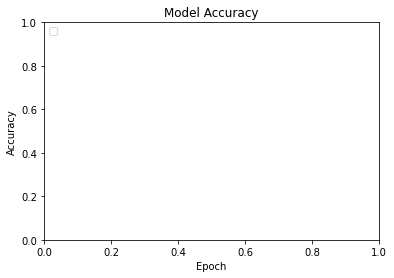

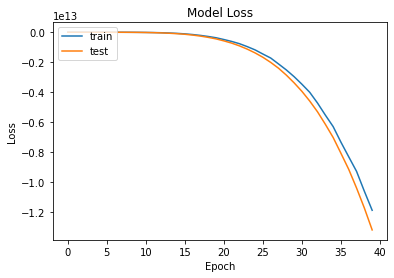

In [49]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
#plt.plot(model_history.history['binary_accurancy'])
#plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()